## Spam Classifier

We all face the problem of spams in our inboxes. Let’s build a spam classifier program in python which can tell whether a given message is spam or not!

## Outline

1. Loading dependencies
2. Loading Data
3. Text Transformation
4. Feature Engineering
5. Visualization
5. Feature Extraction
   - Bag-of-Words
   - TF-IDF
6. Model Building + Evaluation
   - Naive Bayes
   - Logistic Regression
   - Decision Tree
   - Random Forest
7. Model Building : Hyperparameter Tuning + Evaluation
   - Naive Bayes
   - Logistic Regression
   - Decision Tree
   - Random Forest

### 1. Loading dependencies

In [185]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

### 2. Loading Data

https://www.kaggle.com/uciml/sms-spam-collection-dataset/#spam.csv

In [189]:
mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We do not require the columns ‘Unnamed: 2’, ‘Unnamed: 3’ and ‘Unnamed: 4’, so we remove them. We rename the column ‘v1’ as ‘label’ and ‘v2’ as ‘message’. ‘ham’ is replaced by 0 and ‘spam’ is replaced by 1 in the ‘label’ column. Finally we obtain the following dataframe.

In [190]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [191]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [192]:
mails['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [6]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.head()

,labels,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
mails.drop(['labels'], axis = 1, inplace = True)
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### 3. Text Transformation

Before starting with training we must preprocess the messages. First of all, we shall make all the character lowercase. This is because ‘free’ and ‘FREE’ mean the same and we do not want to treat them as two different words.

Then we tokenize each message in the dataset. Tokenization is the task of splitting up a message into pieces and throwing away the punctuation characters.

The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. We can replace all these words by a single word ‘go’. This is called stemming. We are going to use Porter Stemmer, which is a famous stemming algorithm.

We then move on to remove the stop words. Stop words are those words which occur extremely frequently in any text. For example words like ‘the’, ‘a’, ‘an’, ‘is’, ‘to’ etc. These words do not give us any information about the content of the text. Thus it should not matter if we remove these words for the text.

Optional: You can also use n-grams to improve the accuracy. As of now, we only dealt with 1 word. But when two words are together the meaning totally changes. For example, ‘good’ and ‘not good’ are opposite in meaning. Suppose a text contains ‘not good’, it is better to consider ‘not good’ as one token rather than ‘not’ and ‘good’. Therefore, sometimes accuracy is improved when we split the text into tokens of two (or more) words than only word.

In [29]:
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [38]:
# remove special characters, numbers, punctuations
mails['clean_message'] = mails['message'].str.replace('[^a-zA-Z]+',' ')

In [39]:
# remove short words and lower the words
mails['clean_message'] = mails['clean_message'].apply(lambda x: ' '.join([w.lower() for w in x.split() if len(w) > 2]))

In [40]:
# create new variable tokenized message 
tokenized_message = mails['clean_message'].apply(lambda x: x.split())

In [41]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_message
tokenized_message = tokenized_message.apply(lambda x: [stemmer.stem(i) for i in x])

In [42]:
# join tokens into one sentence
for i in range(len(tokenized_message)):
    tokenized_message[i] = ' '.join(tokenized_message[i])
# change mails['clean_message'] to tokenized_message

In [43]:
mails['clean_message']  = tokenized_message

In [44]:
mails.head()

,message,label,clean_message
0,"Go until jurong point, crazy.. Available only ...",0,until jurong point crazi avail onli bugi great...
1,Ok lar... Joking wif u oni...,0,lar joke wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri wkli comp win cup final tkt may tex...
3,U dun say so early hor... U c already then say...,0,dun say earli hor alreadi then say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah don think goe usf live around here though


### 4. Feature Engineering

In [103]:
mails['len'] = mails['message'].apply(lambda x : len(x) - x.count(" "))

In [105]:
mails['long_number'] = mails['message'].apply(lambda x : len(re.findall('\d{7,}',x)))
mails['short_number'] = mails['message'].apply(lambda x : len(re.findall('\d{4,6}',x)))

In [106]:
import string
def count_punct (text):
    count = sum([1 for x in text if x in string.punctuation])
    pp = round(100*count/(len(text)-text.count(" ")),3)
    return pp

In [107]:
mails['punct'] = mails['message'].apply(lambda x : count_punct(x)

In [108]:
def website(text):
    if (len(re.findall('www|http|com|\.co',text))>0):
        return 1
    else:
        return 0

In [110]:
mails['website'] = mails['message'].apply(lambda x : website(x))

In [184]:
mails.head()

,message,label,clean_message,len,long_number,short_number,punct,website
0,"Go until jurong point, crazy.. Available only ...",0,until jurong point crazi avail onli bugi great...,92,0,0,9.783,0
1,Ok lar... Joking wif u oni...,0,lar joke wif oni,24,0,0,25.000,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri wkli comp win cup final tkt may tex...,128,1,4,4.688,1
3,U dun say so early hor... U c already then say...,0,dun say earli hor alreadi then say,39,0,0,15.385,0
4,"Nah I don't think he goes to usf, he lives aro...",0,nah don think goe usf live around here though,49,0,0,4.082,0


### 5. Visualization

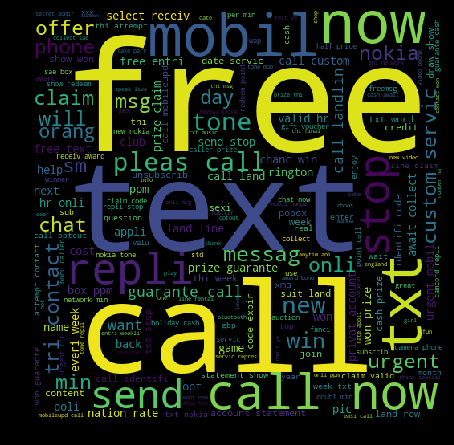

In [45]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['clean_message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (6,6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

As expected, these messages mostly contain the words like ‘FREE’, ‘call’, ‘text’, ‘ringtone’, ‘prize claim’ etc.

Similarly the wordcloud of ham messages is as follows:

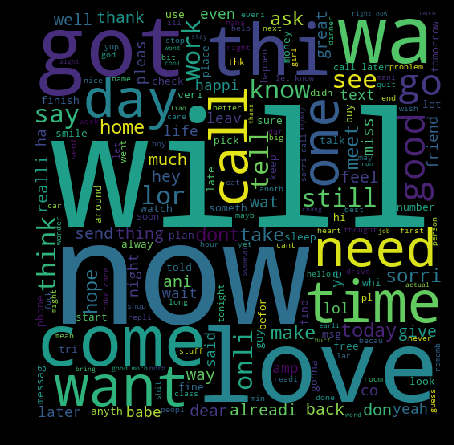

In [46]:
ham_words = ' '.join(list(mails[mails['label'] == 0]['clean_message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (6, 6), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


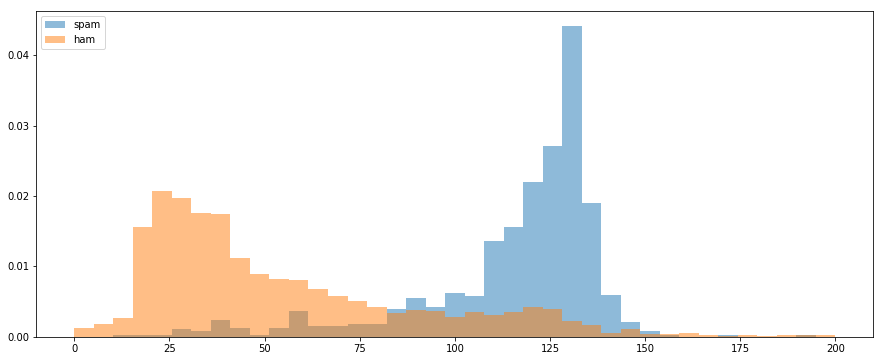

In [113]:
#length
plt.figure(figsize=(15,6))
bins = np.linspace(0,200,num=40)
plt.hist(mails[mails['label']==1]['len'],bins,alpha=0.5,label='spam',normed=True)
plt.hist(mails[mails['label']==0]['len'],bins,alpha =0.5,label ='ham', normed=True)
plt.legend(loc ='upper left')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<function matplotlib.pyplot.show(*args, **kw)>

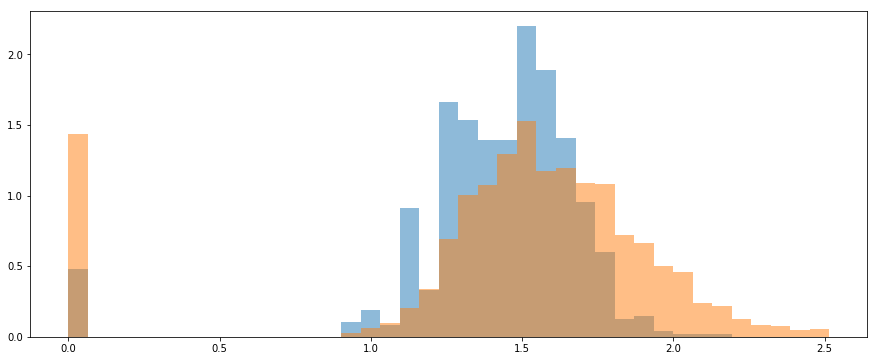

In [115]:
# punctuation 
plt.figure(figsize=(15,6))
i=4
bins = np.linspace(0,40**(1/i),num=40)
plt.hist(mails[mails['label']==1]['punct']**(1/i),bins,normed=True,label ='spam',alpha=0.5)
plt.hist(mails[mails['label']==0]['punct']**(1/i),bins, normed = True, label='ham',alpha=0.5)
plt.show

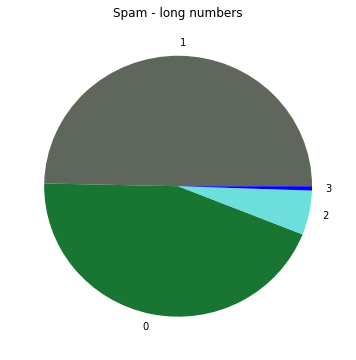

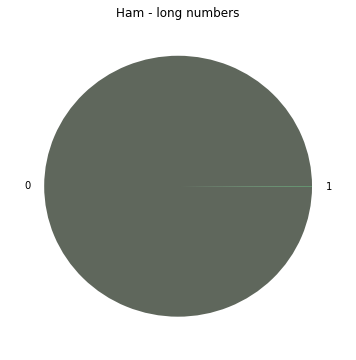

In [121]:
# Long Numbers
plt.figure(figsize=(6,6))
plt.pie(mails[mails['label']==1]['long_number'].value_counts(),labels=['1','0','2','3'], 
           colors=['#5f675c','#197632','#6cdfdc','blue'],)
plt.title("Spam - long numbers")
plt.show()
plt.figure(figsize=(6,6))
plt.pie(mails[mails['label']==0]['long_number'].value_counts(),labels=['0','1'], 
           colors=['#5f675c','#197632'],)
plt.title("Ham - long numbers")
plt.show()

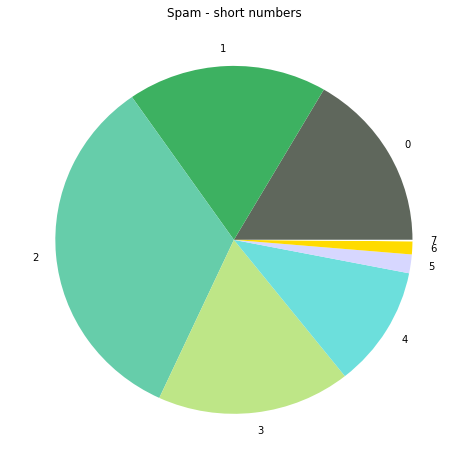

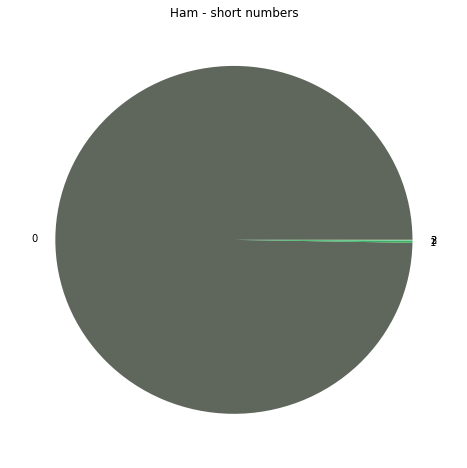

In [123]:
# short Numbers
green_pallete = ['#5f675c','#3db161','#66cdaa','#bee687','#6cdfdc','#d7d7ff','#ffdb00','white']

spam_x = mails[mails['label']==1]['short_number'].value_counts()
spam_x.sort_index(inplace=True)
plt.figure(figsize=(8,8))
plt.pie(spam_x,labels=spam_x.index,startangle=0,colors=green_pallete)
plt.title("Spam - short numbers")
plt.show()

ham_x = mails[mails['label']==0]['short_number'].value_counts()
ham_x.sort_index(inplace=True)
plt.figure(figsize=(8,8))
plt.pie(ham_x,labels=ham_x.index, colors=green_pallete)
plt.title("Ham - short numbers")
plt.show()

### 6. Feature Extraction

In [145]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')

# bag-of-words feature matrix

bow = bow_vectorizer.fit_transform(mails['clean_message'])

In [158]:
mails.columns

Index(['message', 'label', 'clean_message', 'len', 'long_number',
       'short_number', 'punct', 'website'],
      dtype='object')

In [159]:
bow = pd.concat([mails[['len', 'long_number', 'short_number', 'punct', 'website']],pd.DataFrame(bow.toarray())],axis=1)

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(mails['clean_message'])

In [162]:
tfidf = pd.concat([mails[['len', 'long_number', 'short_number', 'punct', 'website']],pd.DataFrame(tfidf.toarray())],axis=1)

### 6. Model Building

In [163]:
from sklearn.model_selection import train_test_split
xtrain_bow, xtest_bow, ytrain_bow, ytest_bow = train_test_split(bow, mails['label'], test_size = 0.25)

In [164]:
xtrain_bow.shape,xtest_bow.shape

((4179, 2919), (1393, 2919))

In [165]:
from sklearn.model_selection import train_test_split
xtrain_tfidf, xtest_tfidf, ytrain_tfidf, ytest_tfidf = train_test_split(tfidf, mails['label'], test_size = 0.25)

#### 6.1 Multinomial Naive Bayes
Generally, Naive Bayes works well on text data. Multinomail Naive bayes is best suited for classification with discrete features.

In [166]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [167]:
prediction = dict()
# bow
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(xtrain_bow,ytrain_bow)
prediction["Multinomial_bow"] = model.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["Multinomial_bow"]))
print('recall score :',recall_score(ytest_bow,prediction["Multinomial_bow"]))
print('precision score :',precision_score(ytest_bow,prediction["Multinomial_bow"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["Multinomial_bow"]))
print(confusion_matrix(ytest_bow,prediction["Multinomial_bow"]))

f1_score : 0.9343065693430658
recall score : 0.9746192893401016
precision score : 0.897196261682243
accuracy score : 0.9806173725771715
[[1174   22]
 [   5  192]]


In [168]:
# tf-idf
model = MultinomialNB()
model.fit(xtrain_tfidf,ytrain_tfidf)
prediction["Multinomial_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["Multinomial_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["Multinomial_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["Multinomial_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["Multinomial_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["Multinomial_tfidf"]))

f1_score : 0.7902439024390243
recall score : 0.9101123595505618
precision score : 0.6982758620689655
accuracy score : 0.9382627422828428
[[1145   70]
 [  16  162]]


#### 6.2 Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain_bow,ytrain_bow)
prediction["LogReg_bow"] = model.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["LogReg_bow"]))
print('recall score :',recall_score(ytest_bow,prediction["LogReg_bow"]))
print('precision score :',precision_score(ytest_bow,prediction["LogReg_bow"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["LogReg_bow"]))
print(confusion_matrix(ytest_bow,prediction["LogReg_bow"]))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.9606299212598426
recall score : 0.9289340101522843
precision score : 0.9945652173913043
accuracy score : 0.9892318736539842
[[1195    1]
 [  14  183]]


In [170]:
# tf-idf
model = LogisticRegression()
model.fit(xtrain_tfidf,ytrain_tfidf)
prediction["LogReg_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["LogReg_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["LogReg_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["LogReg_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["LogReg_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["LogReg_tfidf"]))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.9074626865671641
recall score : 0.8539325842696629
precision score : 0.9681528662420382
accuracy score : 0.9777458722182341
[[1210    5]
 [  26  152]]


#### 6.3 Decision Tree 

In [173]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(xtrain_bow,ytrain_bow)
prediction["dt"] = model.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["dt"]))
print('recall score :',recall_score(ytest_bow,prediction["dt"]))
print('precision score :',precision_score(ytest_bow,prediction["dt"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["dt"]))
print(confusion_matrix(ytest_bow,prediction["dt"]))

f1_score : 0.9185185185185186
recall score : 0.9441624365482234
precision score : 0.8942307692307693
accuracy score : 0.9763101220387652
[[1174   22]
 [  11  186]]


In [174]:
model = DecisionTreeClassifier()
model.fit(xtrain_tfidf,ytrain_tfidf)
prediction["dt_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["dt_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["dt_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["dt_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["dt_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["dt_tfidf"]))

f1_score : 0.9226519337016575
recall score : 0.9382022471910112
precision score : 0.907608695652174
accuracy score : 0.9798994974874372
[[1198   17]
 [  11  167]]


#### 6.4 Random Forest

In [175]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(xtrain_bow,ytrain_bow)
prediction["rf"] = model.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["rf"]))
print('recall score :',recall_score(ytest_bow,prediction["rf"]))
print('precision score :',precision_score(ytest_bow,prediction["rf"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["rf"]))
print(confusion_matrix(ytest_bow,prediction["rf"]))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


f1_score : 0.9498680738786279
recall score : 0.9137055837563451
precision score : 0.989010989010989
accuracy score : 0.9863603732950467
[[1194    2]
 [  17  180]]


In [176]:
model = RandomForestClassifier()
model.fit(xtrain_tfidf,ytrain_tfidf)
prediction["rf_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["rf_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["rf_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["rf_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["rf_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["rf_tfidf"]))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


f1_score : 0.935672514619883
recall score : 0.898876404494382
precision score : 0.975609756097561
accuracy score : 0.9842067480258435
[[1211    4]
 [  18  160]]


### 7. Model Building : Hyperparameter Tuning

#### 7.2 Logistic Regression

In [177]:
from sklearn.model_selection import GridSearchCV

# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
parameters = dict(C=C, penalty=penalty)

# Instantiate the grid search model
grid_lr = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=1, scoring = 'f1')
# Fit the grid search model
grid_lr.fit(xtrain_bow,ytrain_bow)
best_lr = LogisticRegression(penalty=grid_lr.best_params_['penalty'],C=grid_lr.best_params_['C'])
best_lr.fit(xtrain_bow,ytrain_bow)
prediction["LogReg_best_bow"] = best_lr.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["LogReg_best_bow"]))
print('recall score :',recall_score(ytest_bow,prediction["LogReg_best_bow"]))
print('precision score :',precision_score(ytest_bow,prediction["LogReg_best_bow"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["LogReg_best_bow"]))
print(confusion_matrix(ytest_bow,prediction["LogReg_best_bow"]))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

f1_score : 0.9635416666666667
recall score : 0.9390862944162437
precision score : 0.9893048128342246
accuracy score : 0.9899497487437185
[[1194    2]
 [  12  185]]


In [178]:
# Instantiate the grid search model
grid_lr = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=1, scoring = 'f1')
# Fit the grid search model
grid_lr.fit(xtrain_tfidf,ytrain_tfidf)
best_lr = LogisticRegression(penalty=grid_lr.best_params_['penalty'],C=grid_lr.best_params_['C'])
best_lr.fit(xtrain_tfidf,ytrain_tfidf)
prediction["LogReg_best_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["LogReg_best_tfidf"]))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

f1_score : 0.935672514619883
recall score : 0.898876404494382
precision score : 0.975609756097561
accuracy score : 0.9842067480258435
[[1211    4]
 [  18  160]]


#### 7.3 Decision Tree 

In [179]:
parameters = {'max_depth': list(range(1,101))}

# Instantiate the grid search model
grid_dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, verbose=1, scoring = 'f1')

# Fit the grid search model
grid_dt.fit(xtrain_bow,ytrain_bow)

best_dt = DecisionTreeClassifier(criterion='gini',max_depth=grid_dt.best_params_['max_depth'])
best_lr.fit(xtrain_bow,ytrain_bow)
prediction["dt_best_bow"] = best_lr.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["dt_best_bow"]))
print('recall score :',recall_score(ytest_bow,prediction["dt_best_bow"]))
print('precision score :',precision_score(ytest_bow,prediction["dt_best_bow"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["dt_best_bow"]))
print(confusion_matrix(ytest_bow,prediction["dt_best_bow"]))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 14.3min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.9635416666666667
recall score : 0.9390862944162437
precision score : 0.9893048128342246
accuracy score : 0.9899497487437185
[[1194    2]
 [  12  185]]


In [180]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, verbose=1, scoring = 'f1')

# Fit the grid search model
grid_dt.fit(xtrain_tfidf,ytrain_tfidf)

best_dt = DecisionTreeClassifier(criterion='gini',max_depth=grid_dt.best_params_['max_depth'])

best_lr.fit(xtrain_tfidf,ytrain_tfidf)
prediction["LogReg_best_tfidf"] = model.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["LogReg_best_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["LogReg_best_tfidf"]))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 14.0min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.935672514619883
recall score : 0.898876404494382
precision score : 0.975609756097561
accuracy score : 0.9842067480258435
[[1211    4]
 [  18  160]]


#### 7.4 Random Forest Classifier

In [181]:
parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
from sklearn.model_selection import RandomizedSearchCV

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_rf = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
random_rf.fit(xtrain_bow,ytrain_bow)

a = random_rf.best_params_['n_estimators']
b = random_rf.best_params_['min_samples_split']
c = random_rf.best_params_['min_samples_leaf']
d = random_rf.best_params_['max_features']
e = random_rf.best_params_['max_depth']
f = random_rf.best_params_['bootstrap']
print(random_rf.best_params_)
best_rf = RandomForestClassifier(n_estimators=a,min_samples_split=b,min_samples_leaf=c,max_features=d,max_depth=e,bootstrap=f)
best_lr.fit(xtrain_bow,ytrain_bow)
prediction["rf_best_bow"] = best_lr.predict(xtest_bow)
print('f1_score :',f1_score(ytest_bow,prediction["rf_best_bow"]))
print('recall score :',recall_score(ytest_bow,prediction["rf_best_bow"]))
print('precision score :',precision_score(ytest_bow,prediction["rf_best_bow"]))
print('accuracy score :',accuracy_score(ytest_bow,prediction["rf_best_bow"]))
print(confusion_matrix(ytest_bow,prediction["rf_best_bow"]))




Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 26.4min finished


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.9635416666666667
recall score : 0.9390862944162437
precision score : 0.9893048128342246
accuracy score : 0.9899497487437185
[[1194    2]
 [  12  185]]


In [182]:
parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
from sklearn.model_selection import RandomizedSearchCV

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_rf = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
random_rf.fit(xtrain_tfidf,ytrain_tfidf)

a = random_rf.best_params_['n_estimators']
b = random_rf.best_params_['min_samples_split']
c = random_rf.best_params_['min_samples_leaf']
d = random_rf.best_params_['max_features']
e = random_rf.best_params_['max_depth']
f = random_rf.best_params_['bootstrap']
print(random_rf.best_params_)
best_rf = RandomForestClassifier(n_estimators=a,min_samples_split=b,min_samples_leaf=c,max_features=d,max_depth=e,bootstrap=f)
best_lr.fit(xtrain_tfidf,ytrain_tfidf)
prediction["rf_best_tfidf"] = best_lr.predict(xtest_tfidf)
print('f1_score :',f1_score(ytest_tfidf,prediction["rf_best_tfidf"]))
print('recall score :',recall_score(ytest_tfidf,prediction["rf_best_tfidf"]))
print('precision score :',precision_score(ytest_tfidf,prediction["rf_best_tfidf"]))
print('accuracy score :',accuracy_score(ytest_tfidf,prediction["rf_best_tfidf"]))
print(confusion_matrix(ytest_tfidf,prediction["rf_best_tfidf"]))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 26.8min finished


{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


f1_score : 0.9488636363636365
recall score : 0.9382022471910112
precision score : 0.9597701149425287
accuracy score : 0.9870782483847811
[[1208    7]
 [  11  167]]
